# AI-Powered Stock Price Prediction System
# Initial Development Notebook with PyTorch

"""
Project Overview:
-----------------
This notebook implements a comprehensive stock price prediction system using:
- Deep Learning (PyTorch): LSTM, Transformer
- Statistical Models: ARIMA, SARIMA, Prophet, Exponential Smoothing
- Sentiment Analysis: News sentiment integration
- Ensemble Methods: Model combination strategies
- Explainable AI: Feature importance and decision explanations

Requirements Installation:
pip install yfinance pandas numpy scikit-learn torch prophet statsmodels \
            matplotlib seaborn plotly transformers newsapi-python \
            optuna shap tqdm
"""

# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================

In [1]:
!pip install optuna


In [2]:


import warnings
warnings.filterwarnings('ignore')

# Data handling
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# PyTorch - Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Machine learning utilities
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler

# Progress bars
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Using device: cuda


In [4]:
# ============================================================================
# SECTION 2: DATA COLLECTION
# ============================================================================

class StockDataCollector:
    """
    Collects stock data from multiple sources with error handling
    """
    
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        
    def get_stock_data(self):
        """
        Fetch historical stock data from Yahoo Finance
        """
        print(f"Fetching data for {self.ticker}...")
        stock = yf.Ticker(self.ticker)
        df = stock.history(start=self.start_date, end=self.end_date)
        
        if df.empty:
            raise ValueError(f"No data found for {self.ticker}")
            
        print(f"✓ Retrieved {len(df)} trading days of data")
        return df
    
    def add_technical_indicators(self, df):
        """
        Add technical indicators as features
        """
        print("Adding technical indicators...")
        
        # Moving Averages
        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
        
        # Volatility
        df['Volatility'] = df['Close'].rolling(window=20).std()
        
        # RSI (Relative Strength Index)
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        # MACD (Moving Average Convergence Divergence)
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        
        # Bollinger Bands
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        bb_std = df['Close'].rolling(window=20).std()
        df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
        df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
        
        # Volume indicators
        df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA']
        
        # Price momentum
        df['Momentum'] = df['Close'].pct_change(periods=10)
        
        # ATR (Average True Range)
        high_low = df['High'] - df['Low']
        high_close = np.abs(df['High'] - df['Close'].shift())
        low_close = np.abs(df['Low'] - df['Close'].shift())
        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = np.max(ranges, axis=1)
        df['ATR'] = true_range.rolling(14).mean()
        
        # Drop NaN values
        df = df.dropna()
        
        print(f"✓ Added technical indicators, {len(df)} rows remaining after cleaning")
        return df


In [5]:
# ============================================================================
# SECTION 3: EXPLORATORY DATA ANALYSIS
# ============================================================================

class StockDataAnalyzer:
    """
    Performs comprehensive EDA on stock data
    """
    
    def __init__(self, df):
        self.df = df
        
    def plot_price_history(self):
        """
        Visualize stock price history with volume
        """
        fig = make_subplots(
            rows=2, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.03,
            subplot_titles=('Stock Price', 'Volume'),
            row_heights=[0.7, 0.3]
        )
        
        # Price chart
        fig.add_trace(
            go.Candlestick(
                x=self.df.index,
                open=self.df['Open'],
                high=self.df['High'],
                low=self.df['Low'],
                close=self.df['Close'],
                name='Price'
            ),
            row=1, col=1
        )
        
        # Volume chart
        fig.add_trace(
            go.Bar(x=self.df.index, y=self.df['Volume'], name='Volume'),
            row=2, col=1
        )
        
        fig.update_layout(
            title='Stock Price History',
            yaxis_title='Price',
            xaxis_rangeslider_visible=False,
            height=600
        )
        
        fig.show()
        
    def plot_technical_indicators(self):
        """
        Visualize technical indicators
        """
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        
        # Moving Averages
        axes[0, 0].plot(self.df.index, self.df['Close'], label='Close', alpha=0.7)
        axes[0, 0].plot(self.df.index, self.df['SMA_20'], label='SMA 20', alpha=0.7)
        axes[0, 0].plot(self.df.index, self.df['SMA_50'], label='SMA 50', alpha=0.7)
        axes[0, 0].set_title('Moving Averages')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # RSI
        axes[0, 1].plot(self.df.index, self.df['RSI'])
        axes[0, 1].axhline(y=70, color='r', linestyle='--', alpha=0.5)
        axes[0, 1].axhline(y=30, color='g', linestyle='--', alpha=0.5)
        axes[0, 1].set_title('RSI (Relative Strength Index)')
        axes[0, 1].grid(True, alpha=0.3)
        
        # MACD
        axes[1, 0].plot(self.df.index, self.df['MACD'], label='MACD')
        axes[1, 0].plot(self.df.index, self.df['MACD_Signal'], label='Signal')
        axes[1, 0].set_title('MACD')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Bollinger Bands
        axes[1, 1].plot(self.df.index, self.df['Close'], label='Close')
        axes[1, 1].plot(self.df.index, self.df['BB_Upper'], label='Upper', alpha=0.5)
        axes[1, 1].plot(self.df.index, self.df['BB_Lower'], label='Lower', alpha=0.5)
        axes[1, 1].fill_between(self.df.index, self.df['BB_Lower'], self.df['BB_Upper'], alpha=0.1)
        axes[1, 1].set_title('Bollinger Bands')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # Volatility
        axes[2, 0].plot(self.df.index, self.df['Volatility'])
        axes[2, 0].set_title('Volatility (20-day)')
        axes[2, 0].grid(True, alpha=0.3)
        
        # Volume Ratio
        axes[2, 1].bar(self.df.index, self.df['Volume_Ratio'])
        axes[2, 1].axhline(y=1, color='r', linestyle='--', alpha=0.5)
        axes[2, 1].set_title('Volume Ratio')
        axes[2, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    def show_statistics(self):
        """
        Display statistical summary
        """
        print("\n" + "="*60)
        print("STATISTICAL SUMMARY")
        print("="*60)
        
        stats = self.df[['Open', 'High', 'Low', 'Close', 'Volume']].describe()
        print(stats)
        
        # Returns analysis
        returns = self.df['Close'].pct_change()
        print(f"\nDaily Returns Statistics:")
        print(f"Mean Return: {returns.mean():.4%}")
        print(f"Std Dev: {returns.std():.4%}")
        print(f"Sharpe Ratio (annual): {(returns.mean() / returns.std()) * np.sqrt(252):.4f}")
        print(f"Max Daily Gain: {returns.max():.4%}")
        print(f"Max Daily Loss: {returns.min():.4%}")

In [6]:
# ============================================================================
# SECTION 4: DATA PREPROCESSING
# ============================================================================

class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for time series data
    """
    
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]


class DataPreprocessor:
    """
    Prepares data for model training
    """
    
    def __init__(self, df, feature_cols, target_col='Close', sequence_length=60):
        self.df = df
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.sequence_length = sequence_length
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        
    def create_sequences(self, data, target):
        """
        Create sequences for time series prediction
        """
        sequences = []
        targets = []
        
        for i in range(len(data) - self.sequence_length):
            seq = data[i:i + self.sequence_length]
            label = target[i + self.sequence_length]
            sequences.append(seq)
            targets.append(label)
            
        return np.array(sequences), np.array(targets)
    
    def prepare_data(self, train_size=0.8):
        """
        Prepare and split data for training
        """
        print("Preparing data...")
        
        # Extract features and target
        X = self.df[self.feature_cols].values
        y = self.df[self.target_col].values.reshape(-1, 1)
        
        # Split data (time series split)
        split_idx = int(len(X) * train_size)
        
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Scale data
        X_train_scaled = self.scaler_X.fit_transform(X_train)
        X_test_scaled = self.scaler_X.transform(X_test)
        y_train_scaled = self.scaler_y.fit_transform(y_train)
        y_test_scaled = self.scaler_y.transform(y_test)
        
        # Create sequences
        X_train_seq, y_train_seq = self.create_sequences(X_train_scaled, y_train_scaled)
        X_test_seq, y_test_seq = self.create_sequences(X_test_scaled, y_test_scaled)
        
        print(f"✓ Training sequences: {X_train_seq.shape}")
        print(f"✓ Testing sequences: {X_test_seq.shape}")
        
        return (X_train_seq, y_train_seq), (X_test_seq, y_test_seq)
    
    def inverse_transform_predictions(self, predictions):
        """
        Convert scaled predictions back to original scale
        """
        return self.scaler_y.inverse_transform(predictions.reshape(-1, 1))

In [7]:
# ============================================================================
# SECTION 5: PYTORCH MODELS
# ============================================================================

class LSTMModel(nn.Module):
    """
    LSTM model for stock price prediction
    """
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Take the last time step
        last_time_step = lstm_out[:, -1, :]
        
        # Fully connected layers
        out = self.dropout(last_time_step)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out


class TransformerModel(nn.Module):
    """
    Transformer model for stock price prediction
    """
    
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()
        
        self.input_projection = nn.Linear(input_size, d_model)
        
        encoder_layers = TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        
        self.transformer_encoder = TransformerEncoder(
            encoder_layers,
            num_layers=num_layers
        )
        
        self.fc1 = nn.Linear(d_model, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        # Project input to d_model dimensions
        x = self.input_projection(x)
        
        # Transformer encoder
        transformer_out = self.transformer_encoder(x)
        
        # Take the last time step
        last_time_step = transformer_out[:, -1, :]
        
        # Fully connected layers
        out = self.fc1(last_time_step)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out


class ModelTrainer:
    """
    Trains PyTorch models with early stopping and learning rate scheduling
    """
    
    def __init__(self, model, device, lr=0.001):
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5
        )
        
    def train_epoch(self, train_loader):
        """
        Train for one epoch
        """
        self.model.train()
        total_loss = 0
        
        for sequences, targets in train_loader:
            sequences = sequences.to(self.device)
            targets = targets.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(sequences)
            loss = self.criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
            
        return total_loss / len(train_loader)
    
    def evaluate(self, test_loader):
        """
        Evaluate model on test data
        """
        self.model.eval()
        total_loss = 0
        predictions = []
        actuals = []
        
        with torch.no_grad():
            for sequences, targets in test_loader:
                sequences = sequences.to(self.device)
                targets = targets.to(self.device)
                
                outputs = self.model(sequences)
                loss = self.criterion(outputs, targets)
                
                total_loss += loss.item()
                predictions.extend(outputs.cpu().numpy())
                actuals.extend(targets.cpu().numpy())
                
        return total_loss / len(test_loader), np.array(predictions), np.array(actuals)
    
    def train(self, train_loader, test_loader, epochs=100, patience=10):
        """
        Train model with early stopping
        """
        print(f"\nTraining {self.model.__class__.__name__}...")
        
        best_loss = float('inf')
        patience_counter = 0
        train_losses = []
        val_losses = []
        
        for epoch in tqdm(range(epochs)):
            train_loss = self.train_epoch(train_loader)
            val_loss, _, _ = self.evaluate(test_loader)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            self.scheduler.step(val_loss)
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
            
            # Early stopping
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        # Load best model
        self.model.load_state_dict(torch.load('best_model.pth'))
        
        return train_losses, val_losses


In [8]:
# ============================================================================
# SECTION 6: STATISTICAL MODELS
# ============================================================================

class StatisticalModels:
    """
    Implements statistical forecasting models
    """
    
    def __init__(self, data):
        self.data = data
        
    def fit_arima(self, order=(5, 1, 0)):
        """
        Fit ARIMA model
        """
        print(f"Fitting ARIMA{order}...")
        model = ARIMA(self.data, order=order)
        fitted_model = model.fit()
        print("✓ ARIMA fitted")
        return fitted_model
    
    def fit_sarima(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        """
        Fit SARIMA model
        """
        print(f"Fitting SARIMA{order}x{seasonal_order}...")
        model = SARIMAX(self.data, order=order, seasonal_order=seasonal_order)
        fitted_model = model.fit(disp=False)
        print("✓ SARIMA fitted")
        return fitted_model
    
    def fit_prophet(self):
        """
        Fit Prophet model
        """
        print("Fitting Prophet...")
        df_prophet = pd.DataFrame({
        'ds': pd.to_datetime(self.data.index).tz_localize(None),  # Remove timezone
        'y': self.data.values
        })
        
        model = Prophet(daily_seasonality=True, yearly_seasonality=True)
        model.fit(df_prophet)
        print("✓ Prophet fitted")
        return model
    
    def fit_exponential_smoothing(self, seasonal_periods=12):
        """
        Fit Exponential Smoothing model
        """
        print("Fitting Exponential Smoothing...")
        model = ExponentialSmoothing(
            self.data,
            seasonal_periods=seasonal_periods,
            trend='add',
            seasonal='add'
        )
        fitted_model = model.fit()
        print("✓ Exponential Smoothing fitted")
        return fitted_model

In [9]:
# ============================================================================
# SECTION 7: MODEL EVALUATION
# ============================================================================

class ModelEvaluator:
    """
    Comprehensive model evaluation metrics
    """
    
    @staticmethod
    def calculate_metrics(y_true, y_pred):
        """
        Calculate multiple evaluation metrics
        """
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        r2 = r2_score(y_true, y_pred)
        
        # Directional Accuracy
        y_true_diff = np.diff(y_true.flatten())
        y_pred_diff = np.diff(y_pred.flatten())
        directional_accuracy = np.mean((y_true_diff * y_pred_diff) > 0) * 100
        
        metrics = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R²': r2,
            'Directional_Accuracy': directional_accuracy
        }
        
        return metrics
    
    @staticmethod
    def print_metrics(metrics, model_name):
        """
        Print metrics in formatted table
        """
        print(f"\n{'='*60}")
        print(f"EVALUATION METRICS - {model_name}")
        print(f"{'='*60}")
        for metric, value in metrics.items():
            print(f"{metric:.<30} {value:.6f}")
        print(f"{'='*60}\n")
    
    @staticmethod
    def plot_predictions(y_true, y_pred, title="Model Predictions"):
        """
        Visualize predictions vs actual values
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Time series plot
        ax1.plot(y_true, label='Actual', alpha=0.7, linewidth=2)
        ax1.plot(y_pred, label='Predicted', alpha=0.7, linewidth=2)
        ax1.set_title(f'{title} - Time Series')
        ax1.set_xlabel('Time Steps')
        ax1.set_ylabel('Price')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Scatter plot
        ax2.scatter(y_true, y_pred, alpha=0.5)
        ax2.plot([y_true.min(), y_true.max()], 
                 [y_true.min(), y_true.max()], 
                 'r--', lw=2, label='Perfect Prediction')
        ax2.set_title(f'{title} - Scatter Plot')
        ax2.set_xlabel('Actual Price')
        ax2.set_ylabel('Predicted Price')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()



In [10]:
# ============================================================================
# SECTION 8: CROSS-VALIDATION FOR TIME SERIES
# ============================================================================

class TimeSeriesCV:
    """
    Time series cross-validation
    """
    
    def __init__(self, n_splits=5):
        self.n_splits = n_splits
        self.tscv = TimeSeriesSplit(n_splits=n_splits)
        
    def validate_model(self, X, y, model_class, model_params, device):
        """
        Perform walk-forward validation
        """
        print(f"\nPerforming {self.n_splits}-fold Time Series Cross-Validation...")
        
        fold_metrics = []
        
        for fold, (train_idx, val_idx) in enumerate(self.tscv.split(X)):
            print(f"\nFold {fold + 1}/{self.n_splits}")
            
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            # Create data loaders
            train_dataset = TimeSeriesDataset(X_train_fold, y_train_fold)
            val_dataset = TimeSeriesDataset(X_val_fold, y_val_fold)
            
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
            
            # Initialize and train model
            model = model_class(**model_params)
            trainer = ModelTrainer(model, device)
            trainer.train(train_loader, val_loader, epochs=50, patience=5)
            
            # Evaluate
            _, predictions, actuals = trainer.evaluate(val_loader)
            metrics = ModelEvaluator.calculate_metrics(actuals, predictions)
            fold_metrics.append(metrics)
        
        # Aggregate metrics
        avg_metrics = {
            metric: np.mean([fold[metric] for fold in fold_metrics])
            for metric in fold_metrics[0].keys()
        }
        
        std_metrics = {
            metric: np.std([fold[metric] for fold in fold_metrics])
            for metric in fold_metrics[0].keys()
        }
        
        print(f"\n{'='*60}")
        print("CROSS-VALIDATION RESULTS")
        print(f"{'='*60}")
        for metric in avg_metrics:
            print(f"{metric:.<30} {avg_metrics[metric]:.6f} ± {std_metrics[metric]:.6f}")
        print(f"{'='*60}\n")
        
        return avg_metrics, std_metrics


In [11]:
# ============================================================================
# SECTION 9: HYPERPARAMETER TUNING
# ============================================================================

class HyperparameterTuner:
    """
    Optuna-based hyperparameter optimization
    """
    
    def __init__(self, X_train, y_train, X_val, y_val, device):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.device = device
        
    def objective_lstm(self, trial):
        """
        Objective function for LSTM hyperparameter tuning
        """
        # Hyperparameters to tune
        hidden_size = trial.suggest_int('hidden_size', 32, 128, step=32)
        num_layers = trial.suggest_int('num_layers', 1, 3)
        dropout = trial.suggest_float('dropout', 0.1, 0.5)
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
        
        # Create model
        input_size = self.X_train.shape[2]
        model = LSTMModel(input_size, hidden_size, num_layers, dropout)
        
        # Create data loaders
        train_dataset = TimeSeriesDataset(self.X_train, self.y_train)
        val_dataset = TimeSeriesDataset(self.X_val, self.y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Train
        trainer = ModelTrainer(model, self.device, lr=lr)
        trainer.train(train_loader, val_loader, epochs=30, patience=5)
        
        # Evaluate
        val_loss, _, _ = trainer.evaluate(val_loader)
        
        return val_loss
    
    def tune_lstm(self, n_trials=50):
        """
        Run hyperparameter optimization for LSTM
        """
        print(f"\nStarting hyperparameter tuning with {n_trials} trials...")
        
        study = optuna.create_study(
            direction='minimize',
            sampler=TPESampler(seed=42)
        )
        
        study.optimize(self.objective_lstm, n_trials=n_trials, show_progress_bar=True)
        
        print("\n" + "="*60)
        print("HYPERPARAMETER TUNING RESULTS - LSTM")
        print("="*60)
        print(f"Best validation loss: {study.best_value:.6f}")
        print("\nBest hyperparameters:")
        for param, value in study.best_params.items():
            print(f"  {param}: {value}")
        print("="*60 + "\n")
        
        return study.best_params, study.best_value
    
    def objective_transformer(self, trial):
        """
        Objective function for Transformer hyperparameter tuning
        """
        # Hyperparameters to tune
        d_model = trial.suggest_categorical('d_model', [32, 64, 128])
        nhead = trial.suggest_categorical('nhead', [2, 4, 8])
        num_layers = trial.suggest_int('num_layers', 1, 4)
        dropout = trial.suggest_float('dropout', 0.1, 0.5)
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
        
        # Ensure d_model is divisible by nhead
        if d_model % nhead != 0:
            return float('inf')
        
        # Create model
        input_size = self.X_train.shape[2]
        model = TransformerModel(input_size, d_model, nhead, num_layers, dropout)
        
        # Create data loaders
        train_dataset = TimeSeriesDataset(self.X_train, self.y_train)
        val_dataset = TimeSeriesDataset(self.X_val, self.y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Train
        trainer = ModelTrainer(model, self.device, lr=lr)
        trainer.train(train_loader, val_loader, epochs=30, patience=5)
        
        # Evaluate
        val_loss, _, _ = trainer.evaluate(val_loader)
        
        return val_loss
    
    def tune_transformer(self, n_trials=50):
        """
        Run hyperparameter optimization for Transformer
        """
        print(f"\nStarting hyperparameter tuning for Transformer with {n_trials} trials...")
        
        study = optuna.create_study(
            direction='minimize',
            sampler=TPESampler(seed=42)
        )
        
        study.optimize(self.objective_transformer, n_trials=n_trials, show_progress_bar=True)
        
        print("\n" + "="*60)
        print("HYPERPARAMETER TUNING RESULTS - TRANSFORMER")
        print("="*60)
        print(f"Best validation loss: {study.best_value:.6f}")
        print("\nBest hyperparameters:")
        for param, value in study.best_params.items():
            print(f"  {param}: {value}")
        print("="*60 + "\n")
        
        return study.best_params, study.best_value


In [20]:
# ============================================================================
# SECTION 10: ENSEMBLE METHODS
# ============================================================================

class EnsemblePredictor:
    """
    Combines predictions from multiple models using various strategies
    """
    
    def __init__(self):
        self.models = {}
        self.weights = {}
        
    def add_model(self, name, predictions, weight=1.0):
        """
        Add a model's predictions to the ensemble
        """
        self.models[name] = predictions
        self.weights[name] = weight
        
    def simple_average(self):
        """
        Simple average of all predictions
        """
        predictions = np.array(list(self.models.values()))
        return np.mean(predictions, axis=0)
    
    def weighted_average(self):
        """
        Weighted average based on model performance
        """
        total_weight = sum(self.weights.values())
        weighted_sum = np.zeros_like(list(self.models.values())[0])
        
        for name, predictions in self.models.items():
            weighted_sum += predictions * self.weights[name]
            
        return weighted_sum / total_weight
    
    def median_ensemble(self):
        """
        Median of all predictions (robust to outliers)
        """
        predictions = np.array(list(self.models.values()))
        return np.median(predictions, axis=0)
    
    def stacking_ensemble(self, X_meta, y_true):
        """
        Train a meta-learner on model predictions
        """
        from sklearn.linear_model import Ridge
        
        # Create meta-features (predictions from all models)
        meta_features = np.column_stack(list(self.models.values()))
        
        # Train meta-learner
        meta_model = Ridge(alpha=1.0)
        meta_model.fit(meta_features, y_true)
        
        # Get stacked predictions
        stacked_predictions = meta_model.predict(meta_features)
        
        print("\nMeta-model coefficients (model importance):")
        for name, coef in zip(self.models.keys(), meta_model.coef_):
            print(f"  {name}: {coef:.4f}")
            
        return stacked_predictions
    
    def evaluate_all_strategies(self, y_true):
        """
        Evaluate all ensemble strategies
        """
        print("\n" + "="*60)
        print("ENSEMBLE EVALUATION")
        print("="*60)
        
        strategies = {
            'Simple Average': self.simple_average(),
            'Weighted Average': self.weighted_average(),
            'Median Ensemble': self.median_ensemble(),
        }
        
        results = {}
        for strategy_name, predictions in strategies.items():
            metrics = ModelEvaluator.calculate_metrics(y_true, predictions)
            results[strategy_name] = metrics
            print(f"\n{strategy_name}:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value:.6f}")
        
        print("="*60 + "\n")
        
        return results

In [19]:
# ============================================================================
# SECTION 11: NEWS SENTIMENT ANALYSIS
# ============================================================================

class NewsSentimentAnalyzer:
    """
    Analyzes news sentiment for stock prediction enhancement
    """
    
    def __init__(self):
        try:
            from transformers import AutoTokenizer, AutoModelForSequenceClassification
            import torch
            
            # Load FinBERT model for financial sentiment analysis
            self.tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
            self.model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
            self.model.eval()
            print("✓ FinBERT sentiment model loaded")
            
        except Exception as e:
            print(f"Warning: Could not load sentiment model: {e}")
            self.tokenizer = None
            self.model = None
    
    def analyze_sentiment(self, text):
        """
        Analyze sentiment of a single text
        Returns: sentiment score (-1 to 1)
        """
        if self.tokenizer is None or self.model is None:
            return 0.0
        
        try:
            inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
            
            with torch.no_grad():
                outputs = self.model(**inputs)
                predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
                
            # FinBERT outputs: [negative, neutral, positive]
            sentiment_score = predictions[0][2].item() - predictions[0][0].item()
            
            return sentiment_score
            
        except Exception as e:
            print(f"Error analyzing sentiment: {e}")
            return 0.0
    
    def get_news_sentiment_score(self, ticker, date, news_list=None):
        """
        Get aggregated sentiment score for a stock on a given date
        """
        if news_list is None:
            # Placeholder - in production, fetch real news
            return 0.0
        
        sentiments = [self.analyze_sentiment(news) for news in news_list]
        
        if sentiments:
            return np.mean(sentiments)
        return 0.0
    
    def add_sentiment_features(self, df, news_data=None):
        """
        Add sentiment features to dataframe
        """
        print("Adding sentiment features...")
        
        # Placeholder implementation
        # In production, you would fetch real news data
        df['Sentiment_Score'] = 0.0
        df['Sentiment_MA_7'] = 0.0
        
        print("✓ Sentiment features added (placeholder)")
        return df

In [18]:
# ============================================================================
# SECTION 12: EXPLAINABLE AI
# ============================================================================

class ModelExplainer:
    """
    Provides explanations for model predictions
    """
    
    def __init__(self, model, preprocessor, device):
        self.model = model
        self.preprocessor = preprocessor
        self.device = device
        
    def feature_importance_gradient(self, X_sample):
        """
        Calculate feature importance using gradient-based method
        X_sample should be a single sample of shape (sequence_length, features)
        """
        self.model.train()  # Set to training mode for gradient computation
        
        # Ensure X_sample is 3D: (batch_size=1, sequence_length, features)
        if X_sample.ndim == 2:
            X_tensor = torch.FloatTensor(X_sample).unsqueeze(0).to(self.device)
        else:
            X_tensor = torch.FloatTensor(X_sample).to(self.device)
            
        X_tensor.requires_grad = True
        
        # Forward pass
        output = self.model(X_tensor)
        
        # Backward pass
        output.backward()
        
        # Get gradients - average over batch and sequence dimensions
        gradients = X_tensor.grad.abs().mean(dim=(0, 1)).cpu().numpy()
        
        self.model.eval()  # Set back to eval mode
        
        return gradients
    
    def plot_feature_importance(self, X_sample, feature_names):
        """
        Visualize feature importance
        X_sample: single sample of shape (sequence_length, features) or batch of samples
        """
        # Use only the first sample if multiple samples are provided
        if X_sample.ndim == 3:
            X_sample = X_sample[0]
            
        importance = self.feature_importance_gradient(X_sample)
        
        # Sort by importance
        indices = np.argsort(importance)[::-1]
        
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(importance)), importance[indices])
        plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.xlabel('Features')
        plt.ylabel('Importance Score')
        plt.title('Feature Importance for Predictions')
        plt.tight_layout()
        plt.show()
        
        return dict(zip([feature_names[i] for i in indices], importance[indices]))
    
    def explain_prediction(self, X_sample, feature_names):
        """
        Generate natural language explanation for a prediction
        X_sample should be a single sample of shape (sequence_length, features)
        """
        self.model.eval()
        
        # Get prediction
        with torch.no_grad():
            if X_sample.ndim == 2:
                X_tensor = torch.FloatTensor(X_sample).unsqueeze(0).to(self.device)
            else:
                X_tensor = torch.FloatTensor(X_sample).to(self.device)
            prediction = self.model(X_tensor).cpu().numpy()[0]
        
        # Get feature importance
        importance = self.feature_importance_gradient(X_sample)
        
        # Get top features
        top_indices = np.argsort(importance)[::-1][:5]
        top_features = [(feature_names[i], importance[i]) for i in top_indices]
        
        explanation = f"Prediction: {prediction[0]:.2f}\n\n"
        explanation += "Top contributing features:\n"
        for i, (feature, score) in enumerate(top_features, 1):
            explanation += f"{i}. {feature}: {score:.4f}\n"
        
        return explanation


In [22]:
# ============================================================================
# SECTION 13: MAIN EXECUTION PIPELINE
# ============================================================================

def main_pipeline():
    """
    Complete end-to-end pipeline for stock prediction
    """
    
    print("="*80)
    print("STOCK PRICE PREDICTION SYSTEM - COMPLETE PIPELINE")
    print("="*80)
    
    # ========== STEP 1: DATA COLLECTION ==========
    print("\n[STEP 1] Data Collection")
    print("-" * 80)
    
    ticker = 'AAPL'  # Change to any stock ticker
    start_date = '2020-01-01'
    end_date = '2024-12-27'
    
    collector = StockDataCollector(ticker, start_date, end_date)
    df = collector.get_stock_data()
    df = collector.add_technical_indicators(df)
    
    # ========== STEP 2: EXPLORATORY ANALYSIS ==========
    print("\n[STEP 2] Exploratory Data Analysis")
    print("-" * 80)
    
    analyzer = StockDataAnalyzer(df)
    analyzer.show_statistics()
    # Uncomment to show plots:
    analyzer.plot_price_history()
    analyzer.plot_technical_indicators()
    
    # ========== STEP 3: DATA PREPARATION ==========
    print("\n[STEP 3] Data Preparation")
    print("-" * 80)
    
    feature_cols = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'SMA_20', 'SMA_50', 'EMA_20', 'RSI', 'MACD',
        'Volatility', 'Momentum'
    ]
    
    preprocessor = DataPreprocessor(df, feature_cols, sequence_length=60)
    (X_train, y_train), (X_test, y_test) = preprocessor.prepare_data(train_size=0.8)
    
    # Create data loaders
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # ========== STEP 4: HYPERPARAMETER TUNING ==========
    print("\n[STEP 4] Hyperparameter Tuning")
    print("-" * 80)
    
    # Use a small validation set for tuning
    val_size = int(len(X_train) * 0.2)
    X_train_tune, X_val_tune = X_train[:-val_size], X_train[-val_size:]
    y_train_tune, y_val_tune = y_train[:-val_size], y_train[-val_size:]
    
    tuner = HyperparameterTuner(X_train_tune, y_train_tune, X_val_tune, y_val_tune, device)
    
    # Tune LSTM (reduce n_trials for faster execution)
    best_lstm_params, _ = tuner.tune_lstm(n_trials=20)
    
    # Tune Transformer
    best_transformer_params, _ = tuner.tune_transformer(n_trials=20)
    
    # ========== STEP 5: TRAIN MODELS WITH BEST HYPERPARAMETERS ==========
    print("\n[STEP 5] Training Models with Best Hyperparameters")
    print("-" * 80)
    
    input_size = X_train.shape[2]
    
    # Train LSTM
    lstm_model = LSTMModel(
        input_size=input_size,
        hidden_size=best_lstm_params['hidden_size'],
        num_layers=best_lstm_params['num_layers'],
        dropout=best_lstm_params['dropout']
    )
    lstm_trainer = ModelTrainer(lstm_model, device, lr=best_lstm_params['lr'])
    lstm_trainer.train(train_loader, test_loader, epochs=100, patience=15)
    
    # Train Transformer
    transformer_model = TransformerModel(
        input_size=input_size,
        d_model=best_transformer_params['d_model'],
        nhead=best_transformer_params['nhead'],
        num_layers=best_transformer_params['num_layers'],
        dropout=best_transformer_params['dropout']
    )
    transformer_trainer = ModelTrainer(transformer_model, device, lr=best_transformer_params['lr'])
    transformer_trainer.train(train_loader, test_loader, epochs=100, patience=15)
    
    # ========== STEP 6: STATISTICAL MODELS ==========
    print("\n[STEP 6] Training Statistical Models")
    print("-" * 80)
    
    # Prepare data for statistical models (use closing prices)
    train_close = df['Close'].iloc[:len(X_train) + 60]  # +60 for sequence length
    
    stat_models = StatisticalModels(train_close)
    arima_model = stat_models.fit_arima(order=(5, 1, 0))
    prophet_model = stat_models.fit_prophet()
    
    # ========== STEP 7: GENERATE PREDICTIONS ==========
    print("\n[STEP 7] Generating Predictions")
    print("-" * 80)
    
    # Deep learning predictions
    _, lstm_pred, y_true = lstm_trainer.evaluate(test_loader)
    _, transformer_pred, _ = transformer_trainer.evaluate(test_loader)
    
    # Inverse transform predictions
    lstm_pred_original = preprocessor.inverse_transform_predictions(lstm_pred)
    transformer_pred_original = preprocessor.inverse_transform_predictions(transformer_pred)
    y_true_original = preprocessor.inverse_transform_predictions(y_true)
    
    # Statistical model predictions
    arima_pred = arima_model.forecast(steps=len(y_test))
    
    # ========== STEP 8: ENSEMBLE PREDICTIONS ==========
    print("\n[STEP 8] Creating Ensemble Predictions")
    print("-" * 80)
    
    ensemble = EnsemblePredictor()
    ensemble.add_model('LSTM', lstm_pred_original.flatten(), weight=1.0)
    ensemble.add_model('Transformer', transformer_pred_original.flatten(), weight=1.0)
    ensemble.add_model('ARIMA', arima_pred.values, weight=0.5)
    
    ensemble_results = ensemble.evaluate_all_strategies(y_true_original.flatten())
    
    # Get ensemble prediction
    ensemble_pred = ensemble.weighted_average()
    
    # ========== STEP 9: MODEL EVALUATION ==========
    print("\n[STEP 9] Individual Model Evaluation")
    print("-" * 80)
    
    # Evaluate each model
    lstm_metrics = ModelEvaluator.calculate_metrics(y_true_original, lstm_pred_original)
    ModelEvaluator.print_metrics(lstm_metrics, "LSTM")
    
    transformer_metrics = ModelEvaluator.calculate_metrics(y_true_original, transformer_pred_original)
    ModelEvaluator.print_metrics(transformer_metrics, "Transformer")
    
    arima_metrics = ModelEvaluator.calculate_metrics(
        y_true_original[:len(arima_pred)], 
        arima_pred.values.reshape(-1, 1)
    )
    ModelEvaluator.print_metrics(arima_metrics, "ARIMA")
    
    # ========== STEP 10: VISUALIZE PREDICTIONS ==========
    print("\n[STEP 10] Visualizing Predictions")
    print("-" * 80)
    
    # Plot individual model predictions
    ModelEvaluator.plot_predictions(y_true_original, lstm_pred_original, "LSTM Model")
    ModelEvaluator.plot_predictions(y_true_original, transformer_pred_original, "Transformer Model")
    
    # Comprehensive comparison plot
    fig = plt.figure(figsize=(18, 12))
    
    # Main prediction comparison
    ax1 = plt.subplot(3, 2, 1)
    ax1.plot(y_true_original, label='Actual', linewidth=2, alpha=0.8, color='black')
    ax1.plot(lstm_pred_original, label='LSTM', linewidth=1.5, alpha=0.7)
    ax1.plot(transformer_pred_original, label='Transformer', linewidth=1.5, alpha=0.7)
    ax1.plot(arima_pred.values, label='ARIMA', linewidth=1.5, alpha=0.7)
    ax1.plot(ensemble_pred, label='Ensemble', linewidth=2, alpha=0.8, linestyle='--')
    ax1.set_title('All Models - Predictions Comparison', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Stock Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Prediction errors over time
    ax2 = plt.subplot(3, 2, 2)
    lstm_error = y_true_original.flatten() - lstm_pred_original.flatten()
    transformer_error = y_true_original.flatten() - transformer_pred_original.flatten()
    ensemble_error = y_true_original.flatten() - ensemble_pred.flatten()
    ax2.plot(lstm_error, label='LSTM Error', alpha=0.6)
    ax2.plot(transformer_error, label='Transformer Error', alpha=0.6)
    ax2.plot(ensemble_error, label='Ensemble Error', alpha=0.8, linewidth=2)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_title('Prediction Errors Over Time', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Error ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # LSTM scatter plot
    ax3 = plt.subplot(3, 2, 3)
    ax3.scatter(y_true_original, lstm_pred_original, alpha=0.5, s=20)
    ax3.plot([y_true_original.min(), y_true_original.max()], 
             [y_true_original.min(), y_true_original.max()], 
             'r--', lw=2)
    ax3.set_title(f'LSTM - R²={lstm_metrics["R²"]:.4f}', fontsize=11, fontweight='bold')
    ax3.set_xlabel('Actual Price ($)')
    ax3.set_ylabel('Predicted Price ($)')
    ax3.grid(True, alpha=0.3)
    
    # Transformer scatter plot
    ax4 = plt.subplot(3, 2, 4)
    ax4.scatter(y_true_original, transformer_pred_original, alpha=0.5, s=20, color='orange')
    ax4.plot([y_true_original.min(), y_true_original.max()], 
             [y_true_original.min(), y_true_original.max()], 
             'r--', lw=2)
    ax4.set_title(f'Transformer - R²={transformer_metrics["R²"]:.4f}', fontsize=11, fontweight='bold')
    ax4.set_xlabel('Actual Price ($)')
    ax4.set_ylabel('Predicted Price ($)')
    ax4.grid(True, alpha=0.3)
    
    # Model comparison bar chart (RMSE)
    ax5 = plt.subplot(3, 2, 5)
    models = ['LSTM', 'Transformer', 'ARIMA']
    rmse_values = [lstm_metrics['RMSE'], transformer_metrics['RMSE'], arima_metrics['RMSE']]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    bars = ax5.bar(models, rmse_values, color=colors, alpha=0.7)
    ax5.set_title('Model Comparison - RMSE', fontsize=12, fontweight='bold')
    ax5.set_ylabel('RMSE')
    ax5.grid(True, alpha=0.3, axis='y')
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{rmse_values[i]:.2f}',
                ha='center', va='bottom', fontsize=10)
    
    # Model comparison bar chart (Directional Accuracy)
    ax6 = plt.subplot(3, 2, 6)
    dir_acc = [lstm_metrics['Directional_Accuracy'], 
               transformer_metrics['Directional_Accuracy'], 
               arima_metrics['Directional_Accuracy']]
    bars = ax6.bar(models, dir_acc, color=colors, alpha=0.7)
    ax6.set_title('Model Comparison - Directional Accuracy', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Accuracy (%)')
    ax6.set_ylim([0, 100])
    ax6.grid(True, alpha=0.3, axis='y')
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{dir_acc[i]:.1f}%',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.suptitle(f'{ticker} Stock Price Prediction - Comprehensive Analysis', 
                 fontsize=14, fontweight='bold', y=1.002)
    plt.show()
    
    # Interactive Plotly visualization
    print("\nGenerating interactive visualization...")
    fig_interactive = go.Figure()
    
    time_steps = list(range(len(y_true_original)))
    
    fig_interactive.add_trace(go.Scatter(
        x=time_steps, y=y_true_original.flatten(),
        mode='lines', name='Actual',
        line=dict(color='black', width=2)
    ))
    
    fig_interactive.add_trace(go.Scatter(
        x=time_steps, y=lstm_pred_original.flatten(),
        mode='lines', name='LSTM',
        line=dict(color='blue', width=1.5, dash='dot')
    ))
    
    fig_interactive.add_trace(go.Scatter(
        x=time_steps, y=transformer_pred_original.flatten(),
        mode='lines', name='Transformer',
        line=dict(color='orange', width=1.5, dash='dot')
    ))
    
    fig_interactive.add_trace(go.Scatter(
        x=time_steps, y=ensemble_pred.flatten(),
        mode='lines', name='Ensemble (Weighted Avg)',
        line=dict(color='green', width=2, dash='dash')
    ))
    
    fig_interactive.update_layout(
        title=f'{ticker} Stock Price Predictions - Interactive View',
        xaxis_title='Time Steps',
        yaxis_title='Stock Price ($)',
        hovermode='x unified',
        height=600,
        template='plotly_white'
    )
    
    fig_interactive.show()
    
    # ========== STEP 11: EXPLAINABILITY ==========
    print("\n[STEP 11] Model Explainability")
    print("-" * 80)
    
    explainer = ModelExplainer(lstm_model, preprocessor, device)
    
    # Explain a sample prediction
    sample_idx = 0
    explanation = explainer.explain_prediction(X_test[sample_idx], feature_cols)
    print(explanation)
    
    # Feature importance - pass a single sample
    importance_dict = explainer.plot_feature_importance(X_test[0], feature_cols)
    
    print("\n" + "="*80)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*80)
    
    return {
        'models': {
            'lstm': lstm_model,
            'transformer': transformer_model,
            'arima': arima_model
        },
        'predictions': {
            'lstm': lstm_pred_original,
            'transformer': transformer_pred_original,
            'arima': arima_pred,
            'ensemble': ensemble_pred
        },
        'metrics': {
            'lstm': lstm_metrics,
            'transformer': transformer_metrics,
            'arima': arima_metrics
        },
        'preprocessor': preprocessor,
        'actual_values': y_true_original
    }


STOCK PRICE PREDICTION SYSTEM - COMPLETE PIPELINE

[STEP 1] Data Collection
--------------------------------------------------------------------------------
Fetching data for AAPL...
✓ Retrieved 1255 trading days of data
Adding technical indicators...
✓ Added technical indicators, 1206 rows remaining after cleaning

[STEP 2] Exploratory Data Analysis
--------------------------------------------------------------------------------

STATISTICAL SUMMARY
              Open         High          Low        Close        Volume
count  1206.000000  1206.000000  1206.000000  1206.000000  1.206000e+03
mean    154.410226   156.111103   152.839811   154.565484  8.733616e+07
std      39.350360    39.535450    39.232803    39.429871  4.881262e+07
min      55.161608    55.263186    51.420157    54.264336  2.323470e+07
25%     129.503361   131.165198   128.032090   129.689415  5.477882e+07
50%     151.907119   154.149050   150.255545   152.039116  7.482940e+07
75%     177.343802   178.533644   175.397

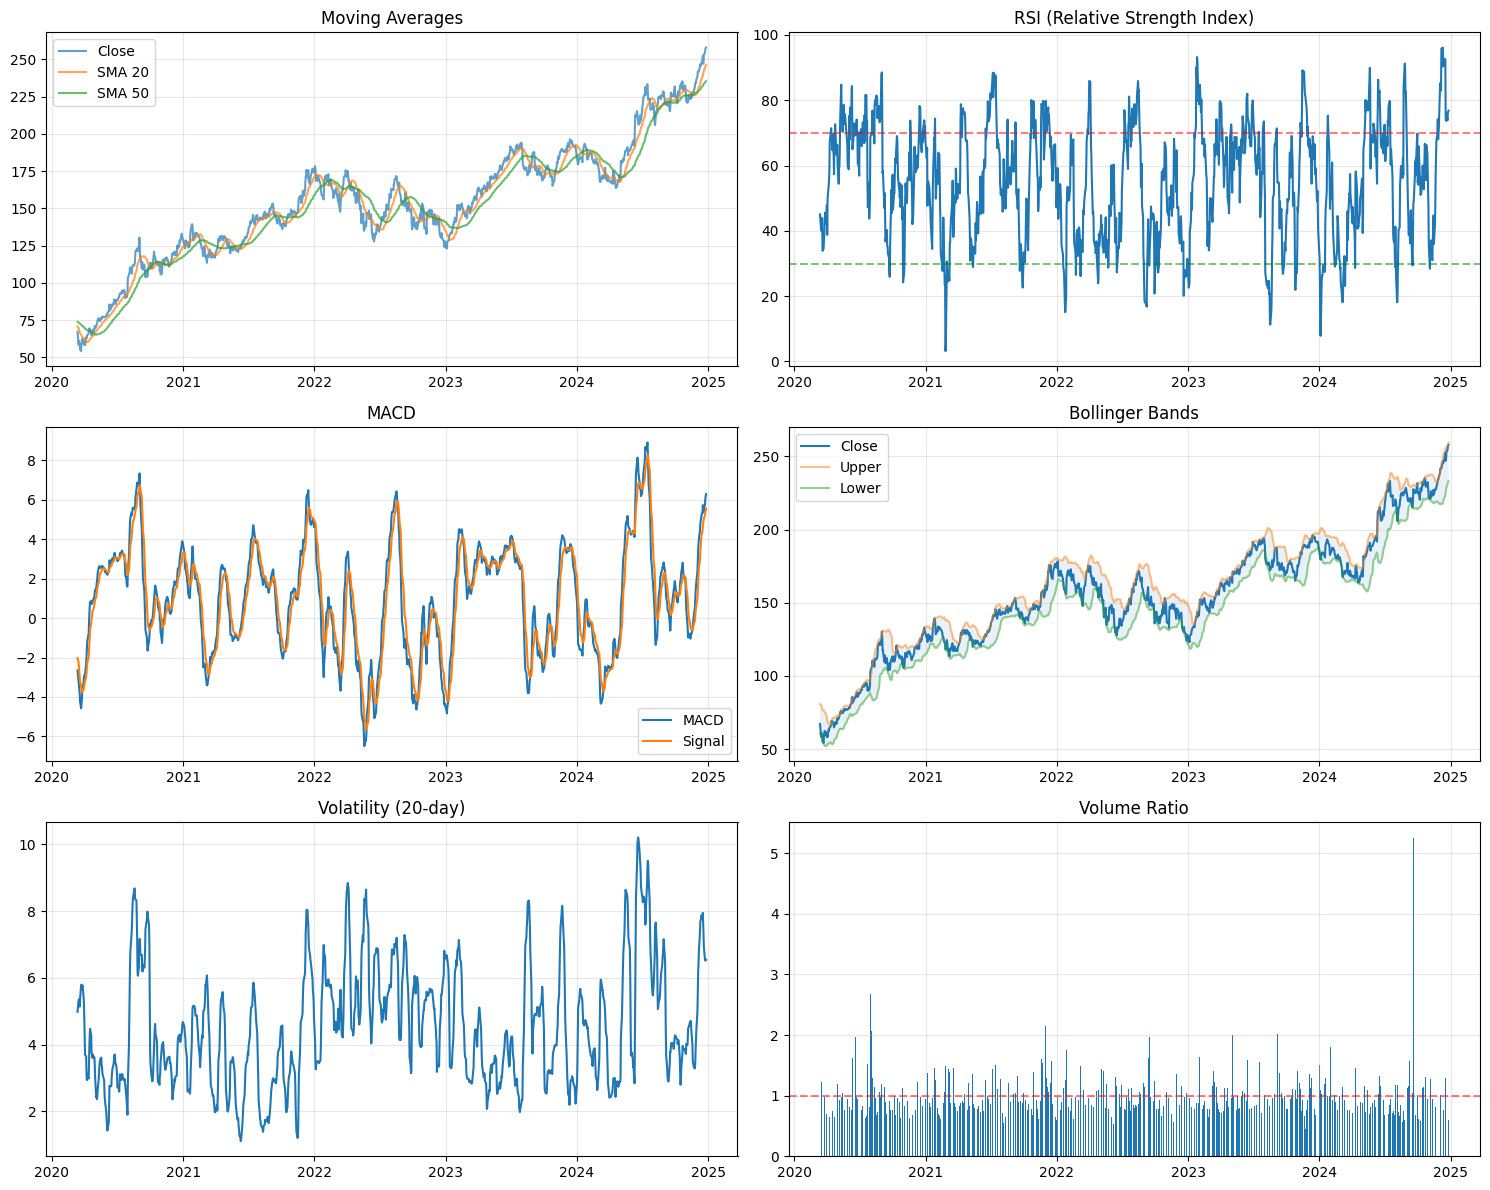

[I 2025-12-27 01:44:27,767] A new study created in memory with name: no-name-d06ea702-d94a-42b4-9f91-8f1e5901130f



[STEP 3] Data Preparation
--------------------------------------------------------------------------------
Preparing data...
✓ Training sequences: (904, 60, 12)
✓ Testing sequences: (182, 60, 12)

[STEP 4] Hyperparameter Tuning
--------------------------------------------------------------------------------

Starting hyperparameter tuning with 20 trials...


  0%|          | 0/20 [00:00<?, ?it/s]


Training LSTMModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.016818, Val Loss: 0.030968


 47%|████▋     | 14/30 [00:01<00:02,  7.79it/s]


Early stopping at epoch 15
[I 2025-12-27 01:44:29,585] Trial 0 finished with value: 0.03096772140512864 and parameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.39279757672456206, 'lr': 0.0006251373574521745, 'batch_size': 16}. Best is trial 0 with value: 0.03096772140512864.

Training LSTMModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.037133, Val Loss: 0.017114


 60%|██████    | 18/30 [00:02<00:01,  8.81it/s]


Early stopping at epoch 19
[I 2025-12-27 01:44:31,645] Trial 1 finished with value: 0.014036777894943953 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3832290311184182, 'lr': 1.1527987128232396e-05, 'batch_size': 16}. Best is trial 1 with value: 0.014036777894943953.

Training LSTMModel...


 33%|███▎      | 10/30 [00:00<00:00, 22.13it/s]


Epoch 10/30 - Train Loss: 0.023562, Val Loss: 0.032940
Early stopping at epoch 11
[I 2025-12-27 01:44:32,112] Trial 2 finished with value: 0.030757613480091095 and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.2216968971838151, 'lr': 0.00037520558551242813, 'batch_size': 64}. Best is trial 1 with value: 0.014036777894943953.

Training LSTMModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.014102, Val Loss: 0.014788


 47%|████▋     | 14/30 [00:01<00:01, 10.84it/s]

Epoch 20/30 - Train Loss: 0.010156, Val Loss: 0.006938


 87%|████████▋ | 26/30 [00:02<00:00,  9.87it/s]


Early stopping at epoch 27
[I 2025-12-27 01:44:34,765] Trial 3 finished with value: 0.0031349451213221378 and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.2465447373174767, 'lr': 0.00023345864076016249, 'batch_size': 16}. Best is trial 3 with value: 0.0031349451213221378.

Training LSTMModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.388280, Val Loss: 0.717198


 77%|███████▋  | 23/30 [00:00<00:00, 30.42it/s]


Epoch 20/30 - Train Loss: 0.046840, Val Loss: 0.018292
Early stopping at epoch 24
[I 2025-12-27 01:44:35,529] Trial 4 finished with value: 0.015572240265707174 and parameters: {'hidden_size': 96, 'num_layers': 1, 'dropout': 0.34301794076057535, 'lr': 3.247673570627447e-05, 'batch_size': 64}. Best is trial 3 with value: 0.0031349451213221378.

Training LSTMModel...


 17%|█▋        | 5/30 [00:00<00:00, 27.44it/s]


Early stopping at epoch 6
[I 2025-12-27 01:44:35,722] Trial 5 finished with value: 0.002221744080695013 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.13906884560255356, 'lr': 0.0011290133559092666, 'batch_size': 64}. Best is trial 5 with value: 0.002221744080695013.

Training LSTMModel...


 20%|██        | 6/30 [00:00<00:01, 19.51it/s]


Early stopping at epoch 7
[I 2025-12-27 01:44:36,043] Trial 6 finished with value: 0.01270325823376576 and parameters: {'hidden_size': 32, 'num_layers': 3, 'dropout': 0.20351199264000677, 'lr': 0.0009717775305059633, 'batch_size': 64}. Best is trial 5 with value: 0.002221744080695013.

Training LSTMModel...


 17%|█▋        | 5/30 [00:00<00:01, 16.61it/s]


Early stopping at epoch 6
[I 2025-12-27 01:44:36,360] Trial 7 finished with value: 0.03914518281817436 and parameters: {'hidden_size': 32, 'num_layers': 3, 'dropout': 0.4100531293444458, 'lr': 0.006584106160121612, 'batch_size': 64}. Best is trial 5 with value: 0.002221744080695013.

Training LSTMModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.148224, Val Loss: 0.345327


 77%|███████▋  | 23/30 [00:00<00:00, 33.71it/s]


Epoch 20/30 - Train Loss: 0.012874, Val Loss: 0.030321
Early stopping at epoch 24
[I 2025-12-27 01:44:37,052] Trial 8 finished with value: 0.028651295850674312 and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.11809091556421523, 'lr': 9.46217535646148e-05, 'batch_size': 64}. Best is trial 5 with value: 0.002221744080695013.

Training LSTMModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.502818, Val Loss: 0.952093


 70%|███████   | 21/30 [00:00<00:00, 34.68it/s]

Epoch 20/30 - Train Loss: 0.386869, Val Loss: 0.738013


100%|██████████| 30/30 [00:00<00:00, 31.60it/s]


Epoch 30/30 - Train Loss: 0.133854, Val Loss: 0.224224
[I 2025-12-27 01:44:38,014] Trial 9 finished with value: 0.22422408560911813 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.31707843326329943, 'lr': 2.6471141828218167e-05, 'batch_size': 64}. Best is trial 5 with value: 0.002221744080695013.

Training LSTMModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.018663, Val Loss: 0.051580


 50%|█████     | 15/30 [00:01<00:01, 12.02it/s]



Early stopping at epoch 16
[I 2025-12-27 01:44:39,309] Trial 10 finished with value: 0.0172720350480328 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.48781484431514655, 'lr': 0.0040877179237697285, 'batch_size': 32}. Best is trial 5 with value: 0.002221744080695013.

Training LSTMModel...


 17%|█▋        | 5/30 [00:00<00:03,  6.55it/s]


Early stopping at epoch 6
[I 2025-12-27 01:44:40,091] Trial 11 finished with value: 0.03270210108409325 and parameters: {'hidden_size': 96, 'num_layers': 2, 'dropout': 0.11053118775043294, 'lr': 0.0017138890273524052, 'batch_size': 16}. Best is trial 5 with value: 0.002221744080695013.

Training LSTMModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.010669, Val Loss: 0.003920


 57%|█████▋    | 17/30 [00:00<00:00, 17.57it/s]

Epoch 20/30 - Train Loss: 0.006733, Val Loss: 0.001452


 83%|████████▎ | 25/30 [00:01<00:00, 17.77it/s]



Early stopping at epoch 26
[I 2025-12-27 01:44:41,514] Trial 12 finished with value: 0.0011333531244114663 and parameters: {'hidden_size': 96, 'num_layers': 1, 'dropout': 0.2236976032175245, 'lr': 0.00019987550005374415, 'batch_size': 32}. Best is trial 12 with value: 0.0011333531244114663.

Training LSTMModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.013401, Val Loss: 0.003487


 57%|█████▋    | 17/30 [00:00<00:00, 17.32it/s]


Early stopping at epoch 18
[I 2025-12-27 01:44:42,511] Trial 13 finished with value: 0.0013302864875489224 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.16916532778317928, 'lr': 0.000159754267808109, 'batch_size': 32}. Best is trial 12 with value: 0.0011333531244114663.

Training LSTMModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.011625, Val Loss: 0.006611


 63%|██████▎   | 19/30 [00:01<00:00, 13.08it/s]


Epoch 20/30 - Train Loss: 0.007687, Val Loss: 0.002230
Early stopping at epoch 20
[I 2025-12-27 01:44:43,981] Trial 14 finished with value: 0.0016449120788214107 and parameters: {'hidden_size': 96, 'num_layers': 2, 'dropout': 0.17499893548386164, 'lr': 0.00013566969734149178, 'batch_size': 32}. Best is trial 12 with value: 0.0011333531244114663.

Training LSTMModel...


 43%|████▎     | 13/30 [00:00<00:01, 14.64it/s]

Epoch 10/30 - Train Loss: 0.033718, Val Loss: 0.011006


Epoch 20/30 - Train Loss: 0.025105, Val Loss: 0.005495


100%|██████████| 30/30 [00:02<00:00, 14.06it/s]


Epoch 30/30 - Train Loss: 0.021819, Val Loss: 0.002720
[I 2025-12-27 01:44:46,143] Trial 15 finished with value: 0.00272017492291828 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.2689251837985763, 'lr': 6.339817364581377e-05, 'batch_size': 32}. Best is trial 12 with value: 0.0011333531244114663.

Training LSTMModel...


 20%|██        | 6/30 [00:00<00:01, 14.81it/s]


Early stopping at epoch 7
[I 2025-12-27 01:44:46,564] Trial 16 finished with value: 0.0012959100810500483 and parameters: {'hidden_size': 96, 'num_layers': 1, 'dropout': 0.17913143173840435, 'lr': 0.00025129406660492687, 'batch_size': 32}. Best is trial 12 with value: 0.0011333531244114663.

Training LSTMModel...


 37%|███▋      | 11/30 [00:00<00:01, 16.63it/s]


Epoch 10/30 - Train Loss: 0.014156, Val Loss: 0.002327
Early stopping at epoch 12
[I 2025-12-27 01:44:47,242] Trial 17 finished with value: 0.0008293396434358632 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2685455800171953, 'lr': 0.0004801588243602259, 'batch_size': 32}. Best is trial 17 with value: 0.0008293396434358632.

Training LSTMModel...


 23%|██▎       | 7/30 [00:00<00:01, 13.71it/s]


Early stopping at epoch 8
[I 2025-12-27 01:44:47,768] Trial 18 finished with value: 0.003713084190773467 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2833646963562315, 'lr': 0.0024153318484831376, 'batch_size': 32}. Best is trial 17 with value: 0.0008293396434358632.

Training LSTMModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.024266, Val Loss: 0.024224


 57%|█████▋    | 17/30 [00:01<00:00, 15.73it/s]
[I 2025-12-27 01:44:48,867] A new study created in memory with name: no-name-26014728-81ca-41dc-b629-e840c50f5445
 57%|█████▋    | 17/30 [00:01<00:00, 15.73it/s]
[I 2025-12-27 01:44:48,867] A new study created in memory with name: no-name-26014728-81ca-41dc-b629-e840c50f5445


Early stopping at epoch 18
[I 2025-12-27 01:44:48,864] Trial 19 finished with value: 0.003664714138722047 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.23994640336858064, 'lr': 0.000588932303219339, 'batch_size': 32}. Best is trial 17 with value: 0.0008293396434358632.

HYPERPARAMETER TUNING RESULTS - LSTM
Best validation loss: 0.000829

Best hyperparameters:
  hidden_size: 64
  num_layers: 1
  dropout: 0.2685455800171953
  lr: 0.0004801588243602259
  batch_size: 32


Starting hyperparameter tuning for Transformer with 20 trials...


  0%|          | 0/20 [00:00<?, ?it/s]


Training TransformerModel...


 17%|█▋        | 5/30 [00:00<00:01, 15.39it/s]


Early stopping at epoch 6
[I 2025-12-27 01:44:49,213] Trial 0 finished with value: 0.003588110984613498 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 1, 'dropout': 0.4464704583099741, 'lr': 0.0006358358856676254, 'batch_size': 64}. Best is trial 0 with value: 0.003588110984613498.

Training TransformerModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.022760, Val Loss: 0.015874


 50%|█████     | 15/30 [00:00<00:00, 19.51it/s]

Epoch 20/30 - Train Loss: 0.013969, Val Loss: 0.015725


 83%|████████▎ | 25/30 [00:01<00:00, 15.95it/s]


Early stopping at epoch 26
[I 2025-12-27 01:44:50,808] Trial 1 finished with value: 0.005022633199890454 and parameters: {'d_model': 32, 'nhead': 8, 'num_layers': 2, 'dropout': 0.21649165607921678, 'lr': 0.000684792009557478, 'batch_size': 64}. Best is trial 0 with value: 0.003588110984613498.

Training TransformerModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.042803, Val Loss: 0.071325


 37%|███▋      | 11/30 [00:01<00:03,  5.67it/s]

Epoch 20/30 - Train Loss: 0.032412, Val Loss: 0.048639


100%|██████████| 30/30 [00:03<00:00,  8.22it/s]



Epoch 30/30 - Train Loss: 0.022799, Val Loss: 0.035094
[I 2025-12-27 01:44:54,496] Trial 2 finished with value: 0.034253605951865516 and parameters: {'d_model': 64, 'nhead': 4, 'num_layers': 3, 'dropout': 0.16820964947491662, 'lr': 1.5673095467235405e-05, 'batch_size': 32}. Best is trial 0 with value: 0.003588110984613498.

Training TransformerModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.033250, Val Loss: 0.011308


 40%|████      | 12/30 [00:01<00:02,  8.36it/s]

Epoch 20/30 - Train Loss: 0.024052, Val Loss: 0.007939


 73%|███████▎  | 22/30 [00:03<00:01,  6.89it/s]



Early stopping at epoch 23
[I 2025-12-27 01:44:57,707] Trial 3 finished with value: 0.0024283606617245823 and parameters: {'d_model': 128, 'nhead': 8, 'num_layers': 1, 'dropout': 0.4637281608315128, 'lr': 5.9750279999602906e-05, 'batch_size': 16}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.080830, Val Loss: 0.015245


 40%|████      | 12/30 [00:01<00:01,  9.51it/s]

Epoch 20/30 - Train Loss: 0.069545, Val Loss: 0.011220


100%|██████████| 30/30 [00:03<00:00,  8.97it/s]



Epoch 30/30 - Train Loss: 0.073313, Val Loss: 0.011094
[I 2025-12-27 01:45:01,079] Trial 4 finished with value: 0.0093934276762108 and parameters: {'d_model': 128, 'nhead': 4, 'num_layers': 3, 'dropout': 0.4687496940092467, 'lr': 1.8427970406864546e-05, 'batch_size': 64}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.064205, Val Loss: 0.024925


 40%|████      | 12/30 [00:02<00:03,  5.82it/s]

Epoch 20/30 - Train Loss: 0.049710, Val Loss: 0.017855


 70%|███████   | 21/30 [00:03<00:01,  5.62it/s]



Early stopping at epoch 22
[I 2025-12-27 01:45:04,841] Trial 5 finished with value: 0.016899419502199937 and parameters: {'d_model': 128, 'nhead': 8, 'num_layers': 1, 'dropout': 0.42087879230161584, 'lr': 1.6736010167825783e-05, 'batch_size': 16}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


 17%|█▋        | 5/30 [00:01<00:05,  4.45it/s]


Early stopping at epoch 6
[I 2025-12-27 01:45:05,990] Trial 6 finished with value: 0.01750830919869865 and parameters: {'d_model': 64, 'nhead': 4, 'num_layers': 2, 'dropout': 0.1463476238100519, 'lr': 0.0038842777547031426, 'batch_size': 16}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


 27%|██▋       | 8/30 [00:00<00:01, 11.90it/s]


Early stopping at epoch 9
[I 2025-12-27 01:45:06,676] Trial 7 finished with value: 0.009424393472727388 and parameters: {'d_model': 128, 'nhead': 4, 'num_layers': 1, 'dropout': 0.38529791488919807, 'lr': 0.0019158219548093154, 'batch_size': 32}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


 20%|██        | 6/30 [00:00<00:01, 15.29it/s]


Early stopping at epoch 7
[I 2025-12-27 01:45:07,083] Trial 8 finished with value: 0.012611684544632832 and parameters: {'d_model': 32, 'nhead': 8, 'num_layers': 2, 'dropout': 0.3034282764658811, 'lr': 0.005280796376895365, 'batch_size': 64}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


 27%|██▋       | 8/30 [00:01<00:03,  6.66it/s]



Early stopping at epoch 9
[I 2025-12-27 01:45:08,306] Trial 9 finished with value: 0.006011160483467393 and parameters: {'d_model': 128, 'nhead': 4, 'num_layers': 3, 'dropout': 0.44858423607508713, 'lr': 0.0025764174425233167, 'batch_size': 32}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


 17%|█▋        | 5/30 [00:01<00:08,  2.94it/s]



Early stopping at epoch 6
[I 2025-12-27 01:45:10,079] Trial 10 finished with value: 0.048634125695874296 and parameters: {'d_model': 128, 'nhead': 2, 'num_layers': 4, 'dropout': 0.3212037354713949, 'lr': 9.88217506715559e-05, 'batch_size': 16}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.025673, Val Loss: 0.016302


 57%|█████▋    | 17/30 [00:02<00:01,  7.39it/s]


Early stopping at epoch 18
[I 2025-12-27 01:45:12,400] Trial 11 finished with value: 0.007882987493455099 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 1, 'dropout': 0.498794514059599, 'lr': 0.00011855684028484752, 'batch_size': 16}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


 17%|█▋        | 5/30 [00:00<00:01, 18.20it/s]


Early stopping at epoch 6
[I 2025-12-27 01:45:12,691] Trial 12 finished with value: 0.010043195138374964 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 1, 'dropout': 0.36408995285589574, 'lr': 0.00022017076589275403, 'batch_size': 64}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


 20%|██        | 6/30 [00:00<00:03,  6.10it/s]


Early stopping at epoch 7
[I 2025-12-27 01:45:13,692] Trial 13 finished with value: 0.07393648723761241 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 1, 'dropout': 0.24338203361806077, 'lr': 0.0006717715238348051, 'batch_size': 16}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.091001, Val Loss: 0.093221


 53%|█████▎    | 16/30 [00:00<00:00, 18.47it/s]

Epoch 20/30 - Train Loss: 0.068733, Val Loss: 0.058661


100%|██████████| 30/30 [00:01<00:00, 17.68it/s]


Epoch 30/30 - Train Loss: 0.055189, Val Loss: 0.041637
[I 2025-12-27 01:45:15,407] Trial 14 finished with value: 0.0416374479730924 and parameters: {'d_model': 32, 'nhead': 8, 'num_layers': 2, 'dropout': 0.3847911208853646, 'lr': 5.390448269343822e-05, 'batch_size': 64}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.046114, Val Loss: 0.028631


 33%|███▎      | 10/30 [00:02<00:05,  3.67it/s]



Early stopping at epoch 11
[I 2025-12-27 01:45:18,165] Trial 15 finished with value: 0.023724968486931175 and parameters: {'d_model': 128, 'nhead': 2, 'num_layers': 4, 'dropout': 0.4985451079657392, 'lr': 0.0006117680740622976, 'batch_size': 16}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.074841, Val Loss: 0.078564


 57%|█████▋    | 17/30 [00:00<00:00, 25.04it/s]

Epoch 20/30 - Train Loss: 0.052113, Val Loss: 0.042726


100%|██████████| 30/30 [00:01<00:00, 21.76it/s]



Epoch 30/30 - Train Loss: 0.040975, Val Loss: 0.039084
[I 2025-12-27 01:45:19,562] Trial 16 finished with value: 0.035058083633581795 and parameters: {'d_model': 64, 'nhead': 8, 'num_layers': 1, 'dropout': 0.42671679825131076, 'lr': 3.776414319785229e-05, 'batch_size': 64}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


 20%|██        | 6/30 [00:01<00:05,  4.52it/s]



Early stopping at epoch 7
[I 2025-12-27 01:45:20,914] Trial 17 finished with value: 0.028888081898912787 and parameters: {'d_model': 128, 'nhead': 8, 'num_layers': 2, 'dropout': 0.36361144192358963, 'lr': 0.009378779924589195, 'batch_size': 16}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.035862, Val Loss: 0.026716


 53%|█████▎    | 16/30 [00:00<00:00, 26.65it/s]

Epoch 20/30 - Train Loss: 0.024055, Val Loss: 0.016141


100%|██████████| 30/30 [00:01<00:00, 25.19it/s]


Epoch 30/30 - Train Loss: 0.023383, Val Loss: 0.008270
[I 2025-12-27 01:45:22,122] Trial 18 finished with value: 0.00479337681705753 and parameters: {'d_model': 64, 'nhead': 2, 'num_layers': 1, 'dropout': 0.33301477388950657, 'lr': 0.00025577108408192286, 'batch_size': 64}. Best is trial 3 with value: 0.0024283606617245823.

Training TransformerModel...


 20%|██        | 6/30 [00:00<00:03,  7.29it/s]


Early stopping at epoch 7
[I 2025-12-27 01:45:22,964] Trial 19 finished with value: 0.0151405551781257 and parameters: {'d_model': 32, 'nhead': 2, 'num_layers': 2, 'dropout': 0.2741874601327157, 'lr': 0.001432154722289983, 'batch_size': 32}. Best is trial 3 with value: 0.0024283606617245823.

HYPERPARAMETER TUNING RESULTS - TRANSFORMER
Best validation loss: 0.002428

Best hyperparameters:
  d_model: 128
  nhead: 8
  num_layers: 1
  dropout: 0.4637281608315128
  lr: 5.9750279999602906e-05
  batch_size: 16


[STEP 5] Training Models with Best Hyperparameters
--------------------------------------------------------------------------------

Training LSTMModel...


 12%|█▏        | 12/100 [00:00<00:05, 16.64it/s]

Epoch 10/100 - Train Loss: 0.016580, Val Loss: 0.012495


 21%|██        | 21/100 [00:01<00:05, 14.33it/s]

Epoch 20/100 - Train Loss: 0.014201, Val Loss: 0.016604


 22%|██▏       | 22/100 [00:01<00:05, 13.90it/s]



Early stopping at epoch 23

Training TransformerModel...


 12%|█▏        | 12/100 [00:01<00:07, 11.27it/s]

Epoch 10/100 - Train Loss: 0.052545, Val Loss: 0.071594


 22%|██▏       | 22/100 [00:02<00:06, 11.38it/s]

Epoch 20/100 - Train Loss: 0.041721, Val Loss: 0.053129


 32%|███▏      | 32/100 [00:03<00:06, 11.07it/s]

Epoch 30/100 - Train Loss: 0.044116, Val Loss: 0.044289


 39%|███▉      | 39/100 [00:03<00:06,  9.98it/s]
/home/adambtw/ml_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/adambtw/ml_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/adambtw/ml_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

01:45:28 - cmdstanpy - INFO - Chain [1] start processing

/home/adambtw/ml_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignor

Epoch 40/100 - Train Loss: 0.036081, Val Loss: 0.043729
Early stopping at epoch 40

[STEP 6] Training Statistical Models
--------------------------------------------------------------------------------
Fitting ARIMA(5, 1, 0)...
✓ ARIMA fitted
Fitting Prophet...


01:45:28 - cmdstanpy - INFO - Chain [1] done processing
/home/adambtw/ml_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/adambtw/ml_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



✓ Prophet fitted

[STEP 7] Generating Predictions
--------------------------------------------------------------------------------

[STEP 8] Creating Ensemble Predictions
--------------------------------------------------------------------------------

ENSEMBLE EVALUATION

Simple Average:
  MSE: 555.164816
  RMSE: 23.561936
  MAE: 20.711761
  MAPE: 9.247459
  R²: -0.104781
  Directional_Accuracy: 55.248619

Weighted Average:
  MSE: 430.231201
  RMSE: 20.742015
  MAE: 18.136057
  MAPE: 8.097515
  R²: 0.143837
  Directional_Accuracy: 55.248619

Median Ensemble:
  MSE: 591.570294
  RMSE: 24.322218
  MAE: 21.627607
  MAPE: 9.672089
  R²: -0.177229
  Directional_Accuracy: 56.353591


[STEP 9] Individual Model Evaluation
--------------------------------------------------------------------------------

EVALUATION METRICS - LSTM
MSE........................... 90.708664
RMSE.......................... 9.524110
MAE........................... 7.537755
MAPE.......................... 3.385555
R²....

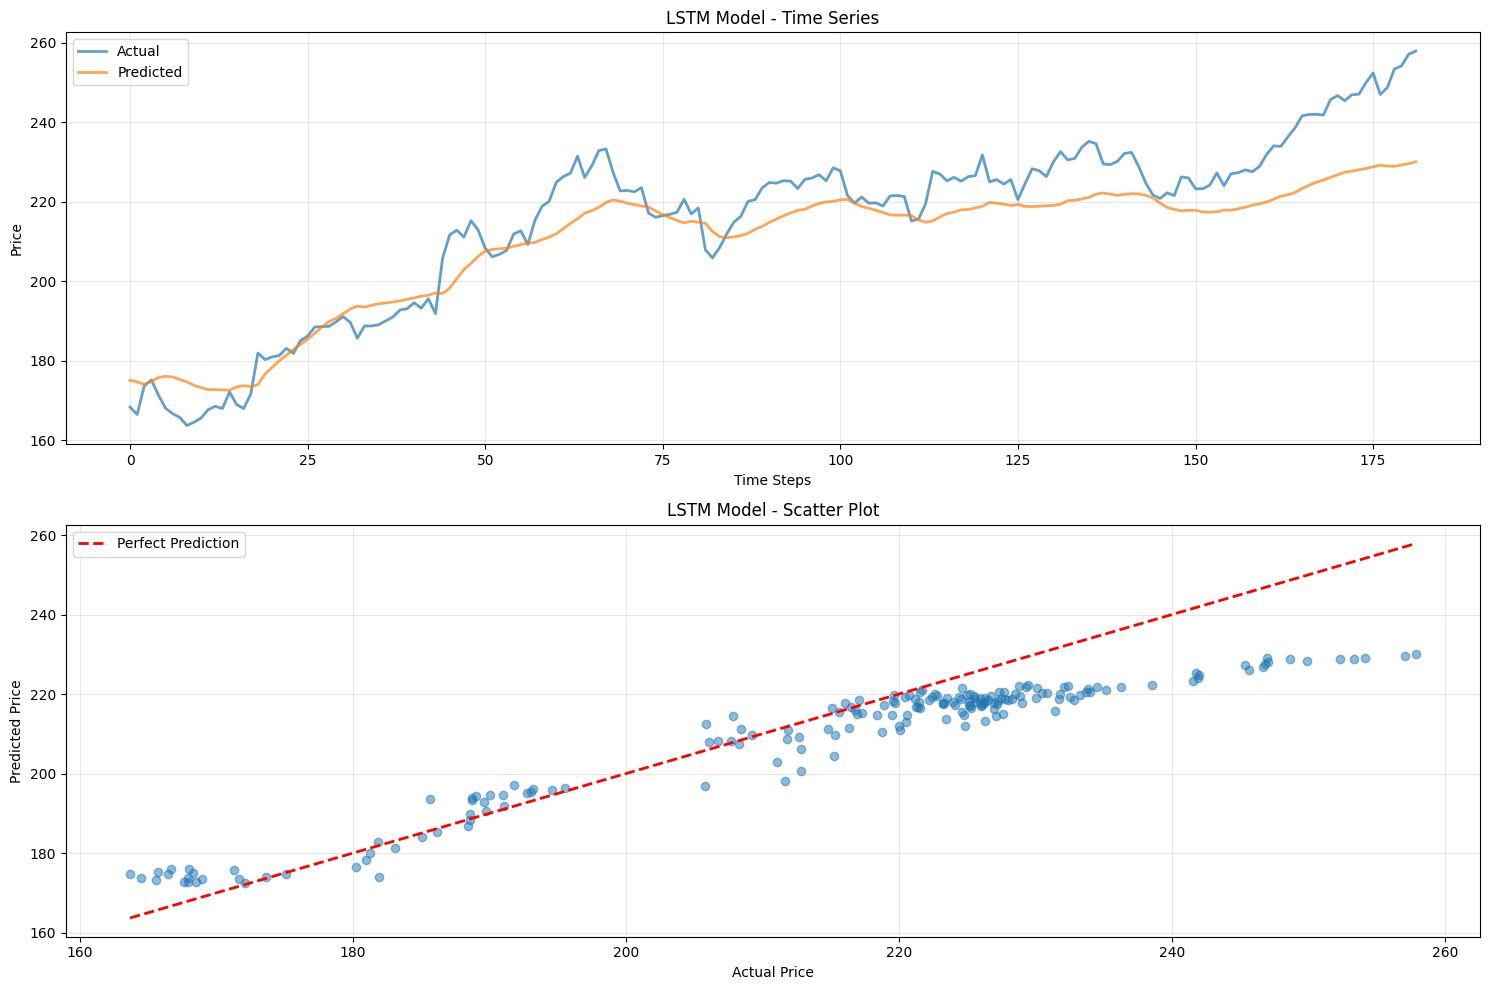

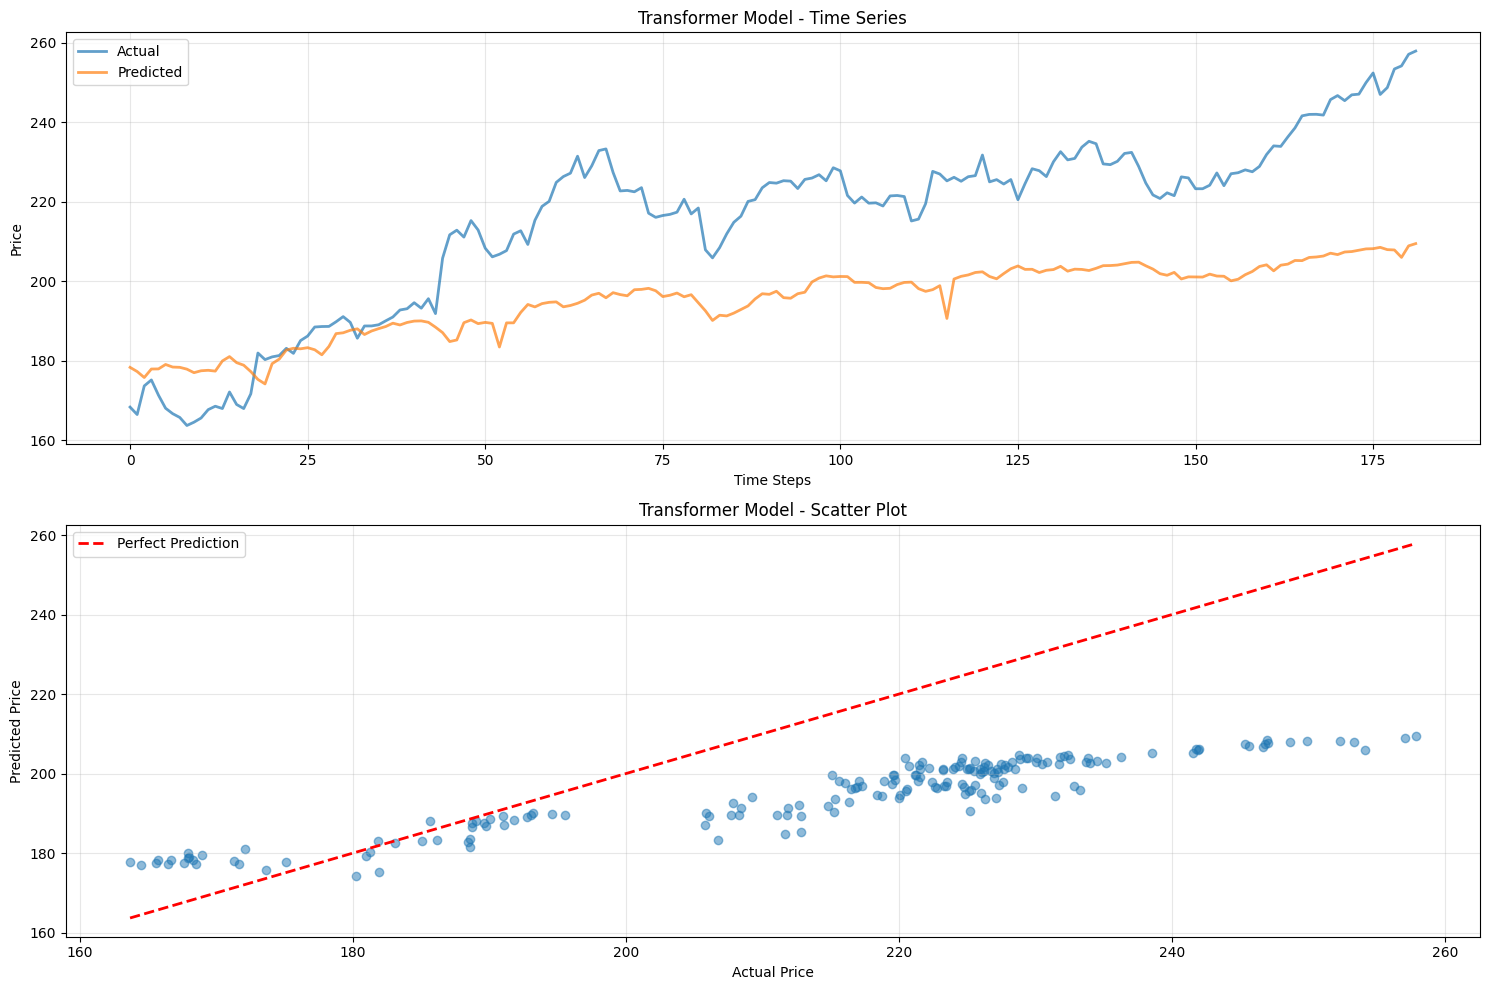

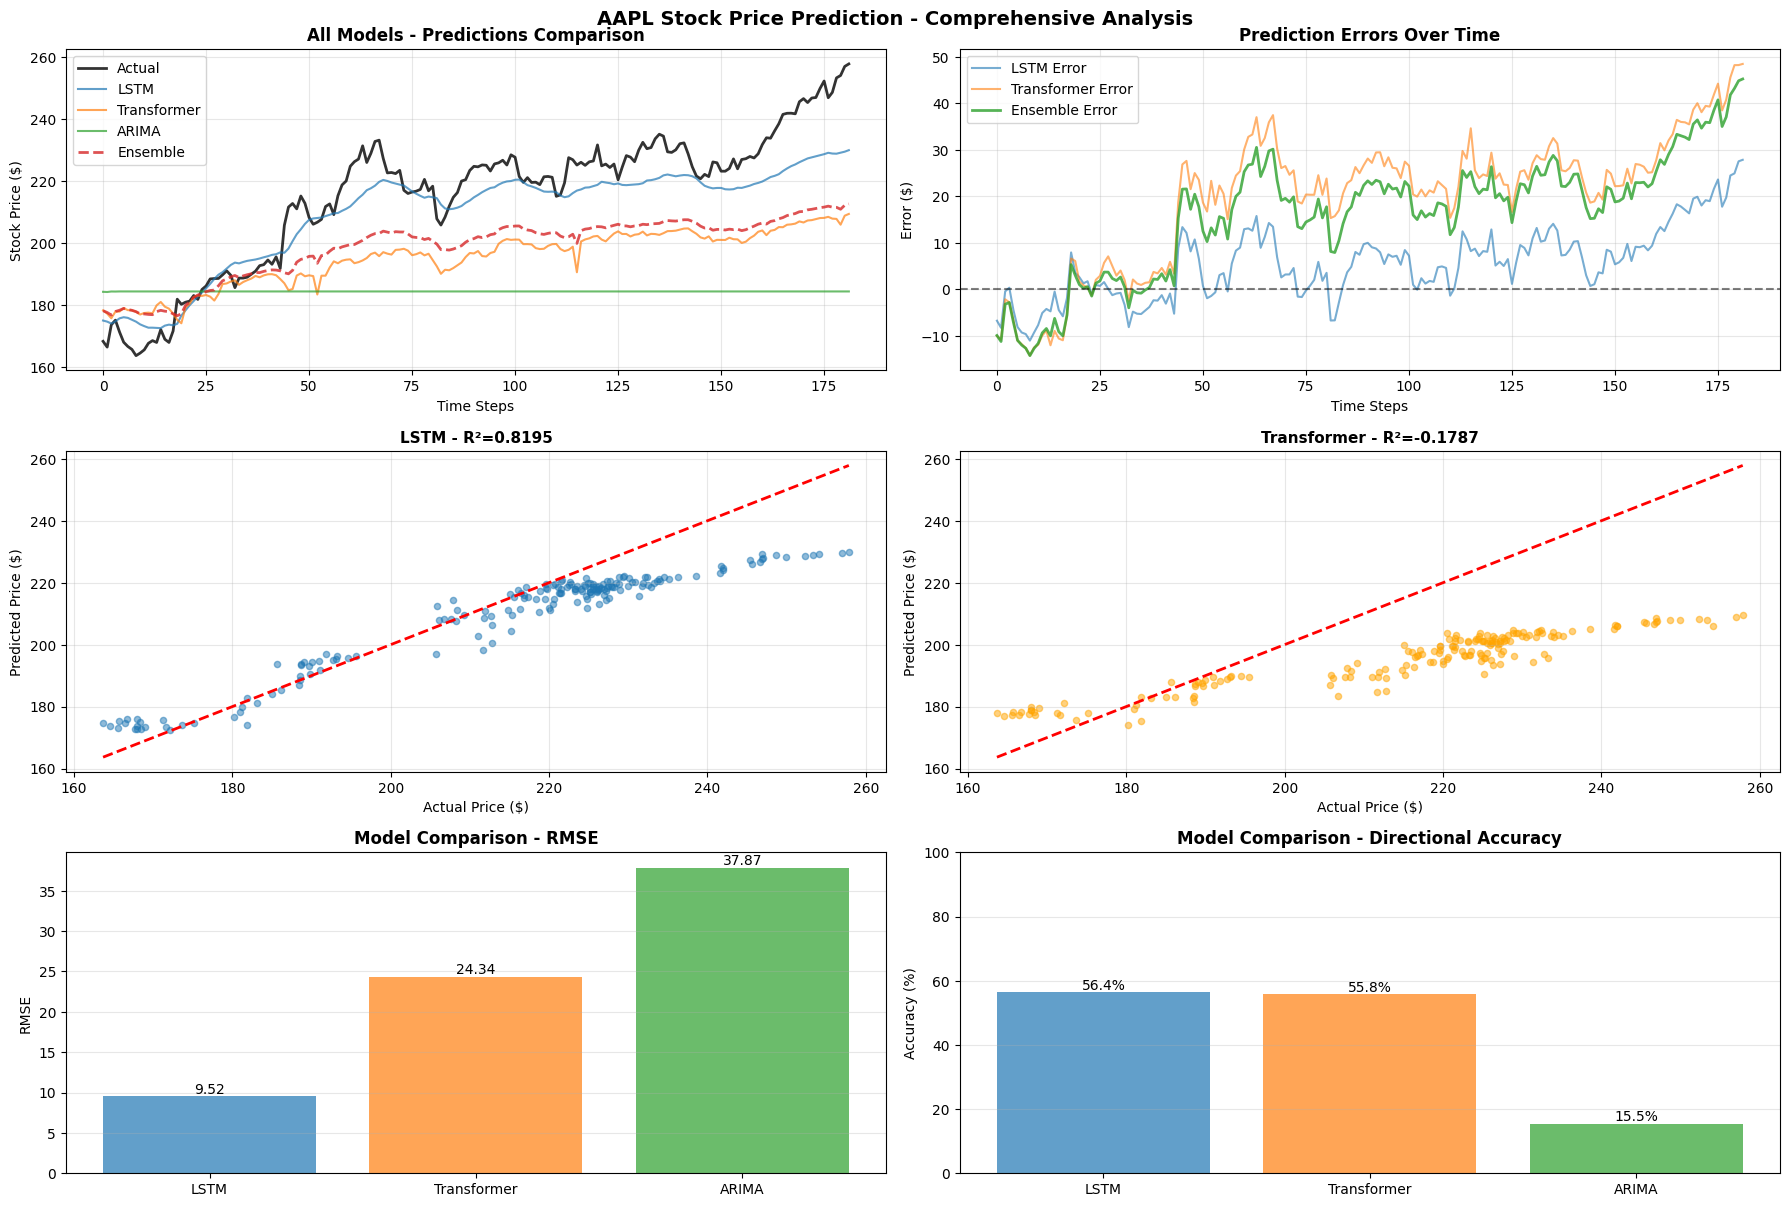


Generating interactive visualization...



[STEP 11] Model Explainability
--------------------------------------------------------------------------------
Prediction: 0.85

Top contributing features:
1. High: 0.0030
2. EMA_20: 0.0029
3. Close: 0.0029
4. Open: 0.0026
5. Low: 0.0025



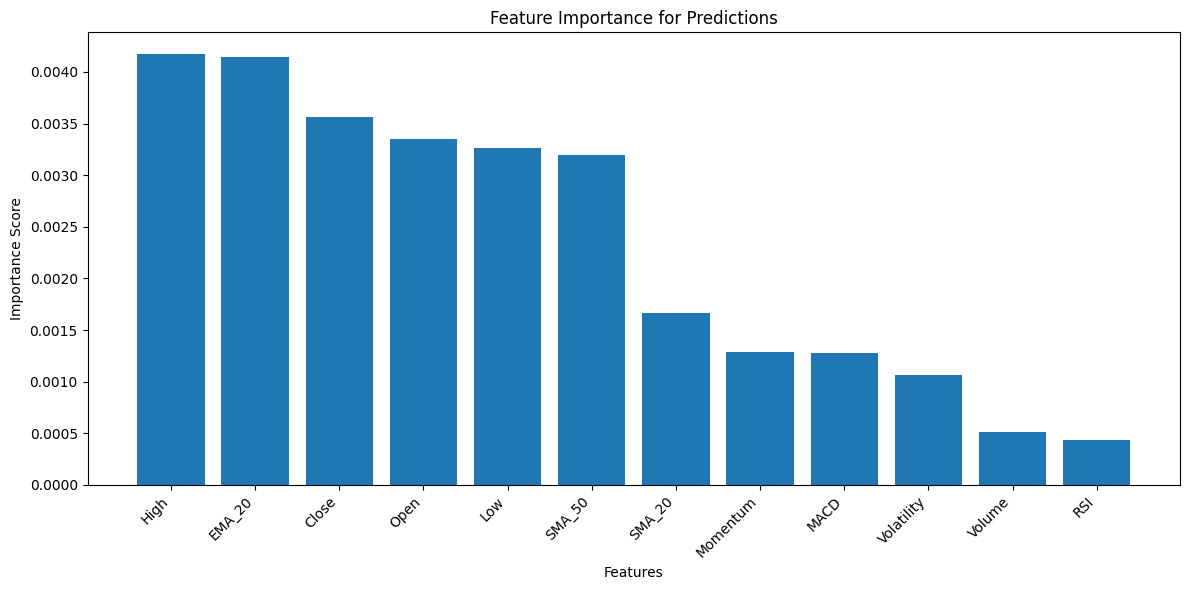


PIPELINE COMPLETED SUCCESSFULLY!


In [23]:
# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Run the complete pipeline
    results = main_pipeline()
    
    # Access results
    # results['models'] - trained models
    # results['predictions'] - all predictions
    # results['metrics'] - evaluation metrics
    # results['preprocessor'] - for inverse transforms